In [1]:
import cv2
import numpy as np
from google.colab import files
from google.colab.patches import cv2_imshow
import tensorflow as tf

In [2]:
model = tf.keras.models.load_model('fashion_classifier_model.h5')

Saving tong.jpg to tong.jpg
1/1 [==============================] - 0s 35ms/step


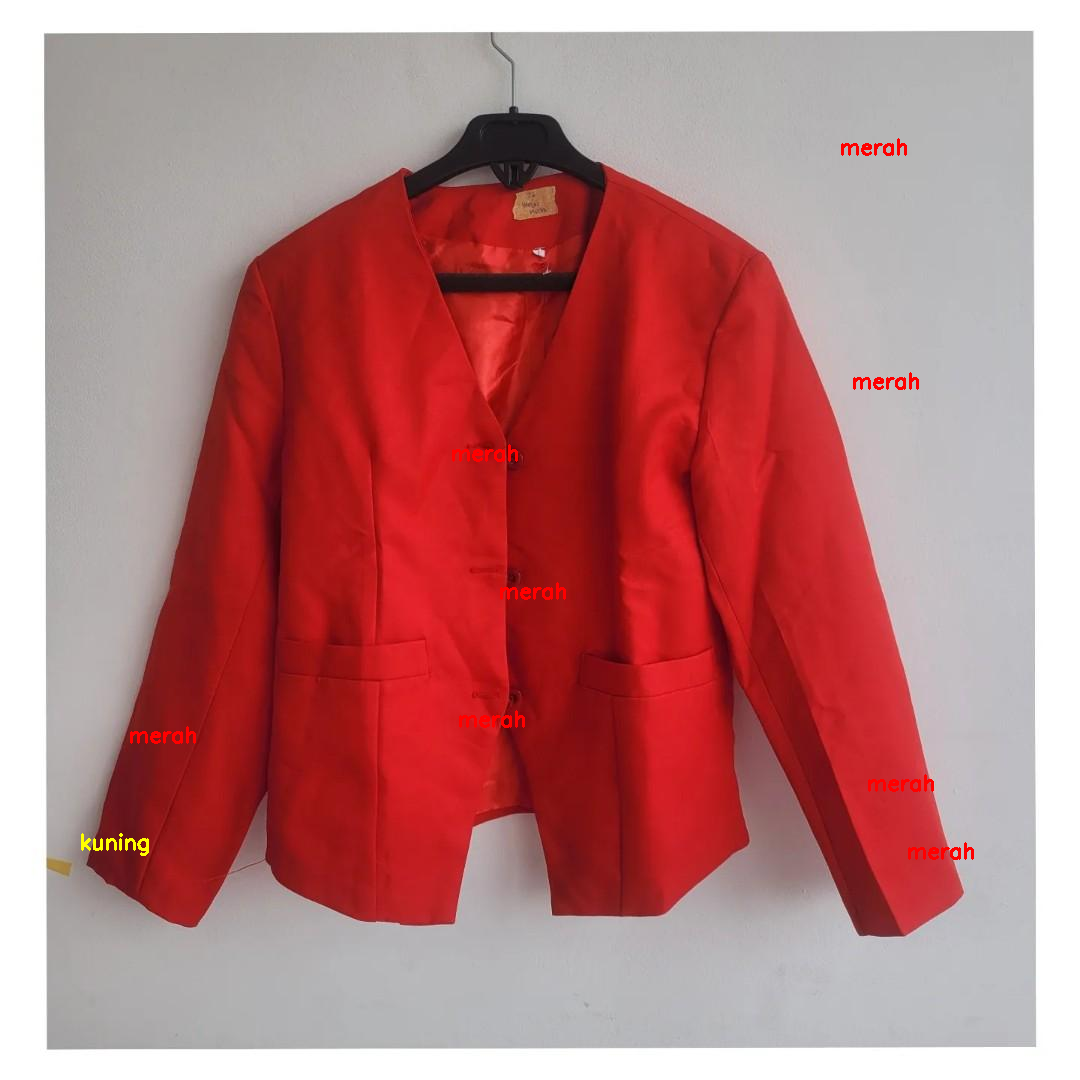

Predicted outfit label: Dress - Warna: merah, kuning, merah, merah, merah, merah, merah, merah, merah
Confidence score (accuracy): 47.98%


In [26]:
# Dictionary for mapping class indices to labels
types_dict = ['Pants', 'Skirt', 'Shirt', 'Blazer', 'Tshirt', 'Jacket', 'Short', 'Dress', 'Top']

def detect_colors(input_image):
    # Convert image to HSV
    hsv = cv2.cvtColor(input_image, cv2.COLOR_BGR2HSV)

    # Define color ranges in HSV
    red_lower = np.array([0, 50, 50])
    red_upper = np.array([10, 255, 255])
    blue_lower = np.array([110, 50, 50])
    blue_upper = np.array([130, 255, 255])
    yellow_lower = np.array([20, 100, 100])
    yellow_upper = np.array([30, 255, 255])
    green_lower = np.array([50, 50, 50])
    green_upper = np.array([70, 255, 255])

    # Create masks for each color
    mask_red = cv2.inRange(hsv, red_lower, red_upper)
    mask_blue = cv2.inRange(hsv, blue_lower, blue_upper)
    mask_yellow = cv2.inRange(hsv, yellow_lower, yellow_upper)
    mask_green = cv2.inRange(hsv, green_lower, green_upper)

    # Combine all masks
    mask_combined = mask_red + mask_blue + mask_yellow + mask_green

    # Apply morphology to clean up the masks
    kernel = np.ones((5, 5), np.uint8)
    mask_combined = cv2.morphologyEx(mask_combined, cv2.MORPH_CLOSE, kernel)

    # Find contours
    contours, _ = cv2.findContours(mask_combined, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Draw bounding boxes and labels
    detected_colors = []
    for contour in contours:
        area = cv2.contourArea(contour)
        if area > 100:
            x, y, w, h = cv2.boundingRect(contour)
            color_text = None
            if mask_red[y + h // 2][x + w // 2] == 255:
                color_text = "merah"
                color_code = (0, 0, 255)
            elif mask_blue[y + h // 2][x + w // 2] == 255:
                color_text = "biru"
                color_code = (255, 0, 0)
            elif mask_yellow[y + h // 2][x + w // 2] == 255:
                color_text = "kuning"
                color_code = (0, 255, 255)
            elif mask_green[y + h // 2][x + w // 2] == 255:
                color_text = "hijau"
                color_code = (0, 255, 0)

            if color_text:
                detected_colors.append(color_text)
                y_pos = y - 10 if y - 10 > 10 else y + 20
                cv2.putText(input_image, color_text, (x + w + 10, y_pos), cv2.FONT_HERSHEY_SIMPLEX, 0.7, color_code, 2)

    return input_image, detected_colors

def predict_outfit(model, img_path, types_dict):
    img = tf.keras.utils.load_img(img_path, target_size=(150, 150))
    img_array = tf.keras.utils.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions[0])
    predicted_label = types_dict[predicted_class]

    confidence_score = predictions[0][predicted_class] * 100

    return predicted_label, confidence_score

# Upload image file in Colab
uploaded = files.upload()

# Get the first uploaded image file
image_files = list(uploaded.keys())
if not image_files:
    print("No image file uploaded.")
else:
    # Take the first uploaded image
    image_path = image_files[0]

    # Read the uploaded image
    img = cv2.imread(image_path)

    # Detect colors
    processed_img, detected_colors = detect_colors(img)

    # Predict outfit
    outfit_label, confidence_score = predict_outfit(model, image_path, types_dict)

    # Combine outfit label with detected colors
    detected_colors_text = ', '.join(detected_colors)
    final_label = f'{outfit_label} - Warna: {detected_colors_text}'
    cv2_imshow(processed_img)
    print(f'Predicted outfit label: {final_label}')
    print("Confidence score (accuracy): {:.2f}%".format(confidence_score))
